<ipython-input-1-6147014b8168>:20: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"], dayfirst=True,errors = "coerce")


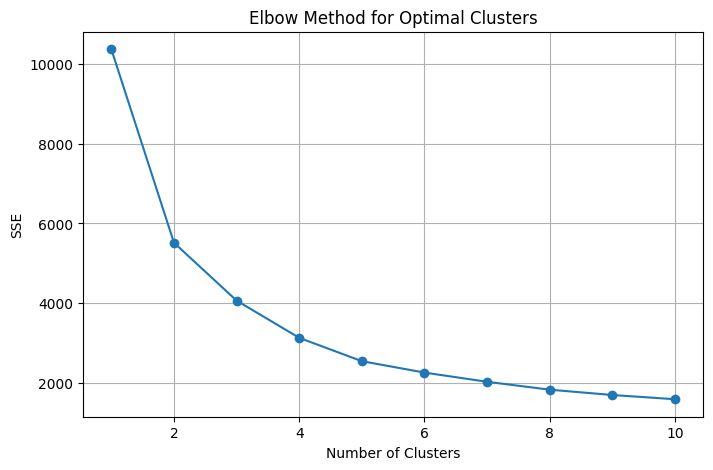


Cluster Summary:
            Recency  Frequency     Monetary  Count
Cluster                                           
0        132.530498   3.268860  1315.036173   1246
1         65.718204  13.596010  8234.520175    401
2        231.172261   1.205193   284.322495   1579
3          3.797414   3.995690  1420.393534    232


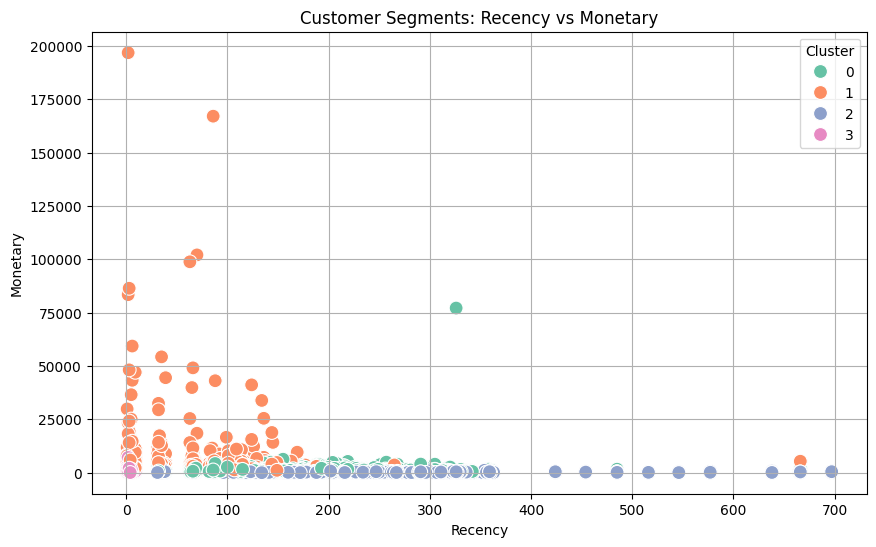

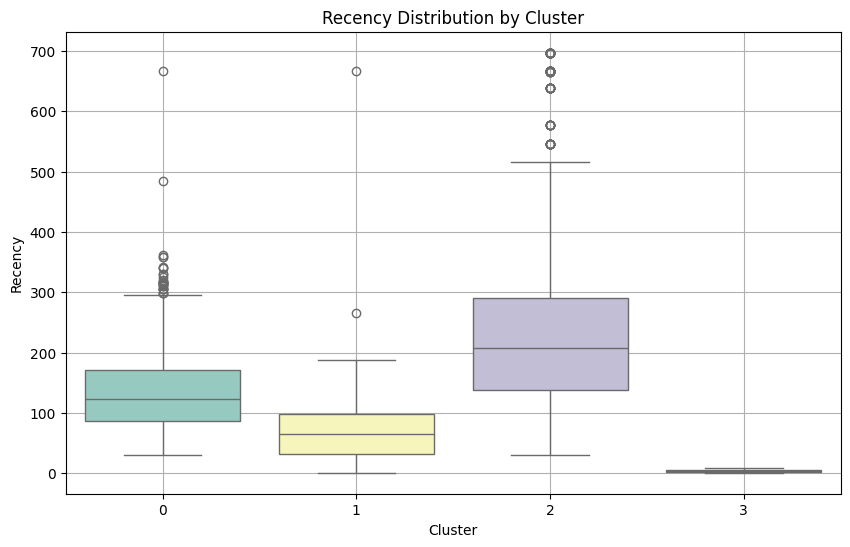

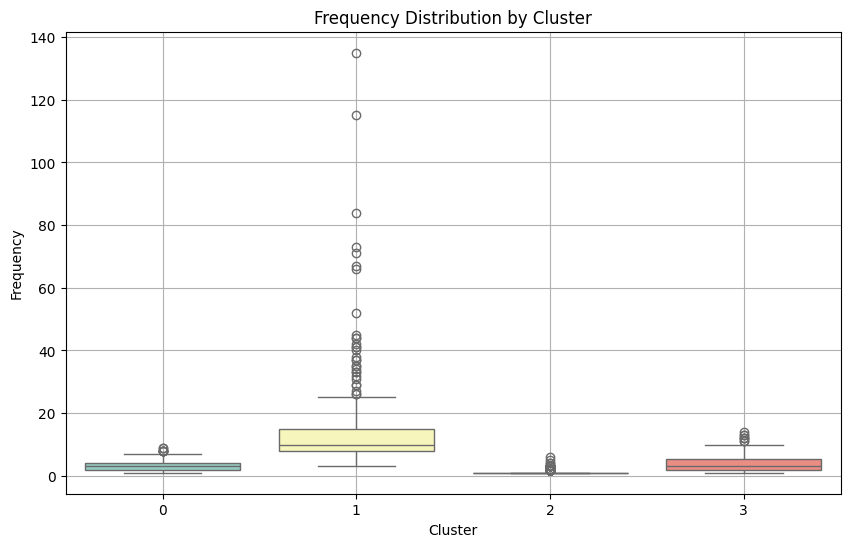

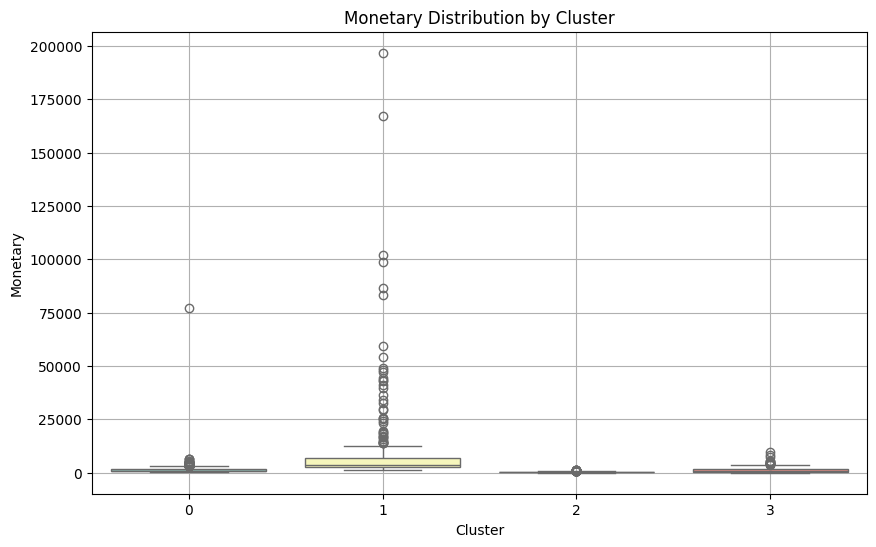

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------------
# 1. Load & Preprocess the Dataset
# ---------------------------------
df = pd.read_csv("/content/9. Customer Segmentation in E-commerce.csv")

# Drop rows with missing CustomerID
df = df[df["CustomerID"].notna()]

# Remove returns (InvoiceNo starting with 'C')
df = df[~df["InvoiceNo"].astype(str).str.startswith('C')]

# Convert InvoiceDate to datetime
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"], dayfirst=True,errors = "coerce")

# Add TotalPrice column
df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]

# ---------------------------------
# 2. RFM Feature Calculation
# ---------------------------------
snapshot_date = df["InvoiceDate"].max() + pd.DateOffset(days=1)

rfm = df.groupby("CustomerID").agg({
    "InvoiceDate": lambda x: (snapshot_date - x.max()).days,  # Recency
    "InvoiceNo": "nunique",  # Frequency
    "TotalPrice": "sum"  # Monetary
}).reset_index()

rfm.columns = ["CustomerID", "Recency", "Frequency", "Monetary"]

# Remove customers with zero or negative Monetary value
rfm = rfm[rfm["Monetary"] > 0]

# ---------------------------------
# 3. Data Transformation (Log + Scaling)
# ---------------------------------
rfm_log = rfm.copy()
rfm_log[["Recency", "Frequency", "Monetary"]] = np.log1p(rfm_log[["Recency", "Frequency", "Monetary"]])

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log[["Recency", "Frequency", "Monetary"]])

# ---------------------------------
# 4. Elbow Method to Find Optimal K
# ---------------------------------
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), sse, marker="o")
plt.title("Elbow Method for Optimal Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.grid(True)
plt.show()

# ---------------------------------
# 5. K-Means Clustering (k = 4)
# ---------------------------------
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
rfm["Cluster"] = kmeans.fit_predict(rfm_scaled)

# ---------------------------------
# 6. Cluster Profiling
# ---------------------------------
cluster_summary = rfm.groupby("Cluster").agg({
    "Recency": "mean",
    "Frequency": "mean",
    "Monetary": "mean",
    "CustomerID": "count"
}).rename(columns={"CustomerID": "Count"})

print("\nCluster Summary:")
print(cluster_summary)

# ---------------------------------
# 7. Cluster Visualizations
# ---------------------------------

# Recency vs Monetary Scatter Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=rfm, x="Recency", y="Monetary", hue="Cluster", palette="Set2", s=100)
plt.title("Customer Segments: Recency vs Monetary")
plt.grid(True)
plt.show()

# Box Plots for Each RFM Dimension by Cluster
plt.figure(figsize=(10, 6))
sns.boxplot(data=rfm, x="Cluster", y="Recency", hue="Cluster", palette="Set3", legend=False)
plt.title("Recency Distribution by Cluster")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(data=rfm, x="Cluster", y="Frequency", hue="Cluster", palette="Set3", legend=False)
plt.title("Frequency Distribution by Cluster")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(data=rfm, x="Cluster", y="Monetary", hue="Cluster", palette="Set3", legend=False)
plt.title("Monetary Distribution by Cluster")
plt.grid(True)
plt.show()
